## Импорты


In [4]:
# pip install -q einops

In [5]:
# pip install -q torch_optimizer


In [6]:
# import torch_optimizer as optim

In [7]:
import os
import time
import requests
from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, precision_score, recall_score, accuracy_score, roc_auc_score,f1_score
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


from PIL import Image

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torch
from torch import nn
import torchvision
from torchvision import transforms

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import shutil
from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2, style='whitegrid')

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(device)

cuda


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## data

In [10]:
!unzip -q "/content/drive/MyDrive/Test tasks/kontur/generated-or-not.zip"


In [11]:
train = pd.read_csv('train.csv')
test_sub = pd.read_csv('test.csv')
files = np.array(os.listdir('images'))

In [12]:
count_dots = lambda s:s.count('.')
(train.id.apply(count_dots)>1).sum(),(train.id.apply(count_dots)==0).sum()

(0, 166)

т.е в названиях нет точек, и в 166 изобр нет формата данных

In [13]:
def add_extension(filename):
    if '.' not in filename:
        for file_1 in files:
            if filename in file_1:
                return file_1
    return filename


In [14]:
add_extension('bk1fxbggAO')

'bk1fxbggAO.png'

In [15]:
train['id'] = train['id'].apply(add_extension)
test_sub['id'] = test_sub['id'].apply(add_extension)

In [16]:
(test_sub.id.apply(count_dots)==0).sum(),(train.id.apply(count_dots)==0).sum()

(0, 0)

исправил то что у некоторых названий файлов не было формата (.jpg.png...)

In [17]:
train.target.value_counts()

target
0    667
1    345
Name: count, dtype: int64

In [18]:
## веса для наших классов
# weights =  torch.tensor([(667+345)/(2*667), (667 + 345) / (2 * 345)])
# weights

In [19]:
# i  = np.random.randint(train.shape[0])
# image = train.id[i]
# print(image)
# Image.open(f'images/{image}')

###

##more data


data taken from [here](https://www.kaggle.com/datasets/superpotato9/dalle-recognition-dataset/data)



взял только часть данных, 1000-1500 изображений каждого класса

In [ ]:
!unzip -q '/content/drive/MyDrive/Test tasks/kontur/add_data.zip'

In [ ]:
len(os.listdir('/content/0')),len(os.listdir('/content/1'))

(1168, 1600)

In [ ]:
real = pd.DataFrame({'image':os.listdir('/content/0'),'label':0})
real[['image']] = real[['image']].apply(lambda x:'/content/0/'+x)

In [ ]:
byai = pd.DataFrame({'image':os.listdir('/content/1'),'label':1})
byai[['image']] = byai[['image']].apply(lambda x:'/content/1/'+x)

In [ ]:
# Image.open(byai.image.loc[100])

##swin


In [1]:
!pip install -U -q evaluate transformers datasets>=2.14.5 accelerate>=0.27 mlflow 2>/dev/null

In [37]:
import warnings
warnings.filterwarnings("ignore")

import gc
import numpy as np
import pandas as pd
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    f1_score  )

from imblearn.over_sampling import RandomOverSampler
import accelerate
import evaluate
from datasets import Dataset, Image, ClassLabel
from transformers import (
    TrainingArguments,
    Trainer,
    ViTImageProcessor,
    ViTForImageClassification,
    DefaultDataCollator,
    AutoImageProcessor,
    AutoModel,
    AutoModelForImageClassification,
    SwinForImageClassification,
    Swinv2ForImageClassification,
    AutoFeatureExtractor
)
import torch
from torch.utils.data import DataLoader


In [38]:
device

'cuda'

In [39]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [40]:
temp = train.copy()
temp[['id']] = train[['id']].apply(lambda x:'images/'+x)

In [41]:
temp.rename(columns = {'id':'image',"target":'label'},inplace=True)
# temp = pd.concat([real,temp, byai])

In [42]:
# files = list(temp.image)
# images_to_delete = [file for file in files if not file.endswith(('.png', '.jpg', '.jpeg'))]
# print(images_to_delete)
# # for image in images_to_delete:
#     # os.remove(image)
# temp = temp[~temp.image.isin(images_to_delete) ]
# files = list(temp.image)
# images_to_delete = [file for file in files if not file.endswith(('.png', '.jpg', '.jpeg'))]
# print(images_to_delete)

In [43]:
temp.shape

(1012, 2)

In [44]:
dataset = Dataset.from_pandas(temp).cast_column("image", Image())

In [45]:
labels_list = [0,1]
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)
dataset = dataset.cast_column('label', ClassLabels)
dataset = dataset.train_test_split(test_size=0.1, shuffle=True,stratify_by_column="label")
train_data = dataset['train']
test_data = dataset['test']

Casting the dataset:   0%|          | 0/1012 [00:00<?, ? examples/s]

In [76]:
processor =  ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

In [77]:
image_mean, image_std = processor.image_mean, processor.image_std

size = processor.size["height"]
print("Size: ", size)
normalize = torchvision.transforms.Normalize(mean=image_mean, std=image_std)

Size:  224


In [78]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
train_transform = transforms.Compose([
  transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomChoice([
    transforms.ColorJitter(brightness=0.2),
    transforms.ColorJitter(contrast=0.2),
    transforms.ColorJitter(saturation=0.2),
    transforms.ColorJitter(hue=0.05),
  ]),
  transforms.RandomChoice([
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop((IMG_HEIGHT, IMG_WIDTH), scale=(0.8, 1.2)),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2),
  ]),
  transforms.RandomChoice([
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 0.5)),
  ]),
  transforms.ToTensor(),
  normalize
])

val_transform = transforms.Compose([
  transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
  transforms.ToTensor(),
  normalize
])

In [79]:
def train_transforms(examples):
    examples['pixel_values'] = [train_transform(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [val_transform(image.convert("RGB")) for image in examples['image']]
    return examples

In [80]:
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

In [87]:
feature_extractor = AutoFeatureExtractor.from_pretrained("Nahrawy/AIorNot")
model = AutoModelForImageClassification.from_pretrained("Nahrawy/AIorNot")
model.classifier = nn.Sequential(
    model.classifier,
    nn.Sigmoid()
)

In [88]:
model.classifier

Sequential(
  (0): Linear(in_features=768, out_features=2, bias=True)
  (1): Sigmoid()
)

In [89]:
print(model.num_parameters(only_trainable=True) / 1e6)

27.520892


In [90]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    label_ids = eval_pred.label_ids

    predicted_labels = predictions.argmax(axis=1)
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']
    return {
        "accuracy": acc_score
    }


In [91]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [92]:
metric_name = "accuracy"
model_name = "Nahrawy_with_sigmoid"
num_train_epochs = 5

args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none",
    logging_steps =10
)

In [93]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,

)

In [94]:
trainer.evaluate()

{'eval_loss': 0.5218173861503601,
 'eval_accuracy': 0.803921568627451,
 'eval_runtime': 2.3532,
 'eval_samples_per_second': 43.346,
 'eval_steps_per_second': 1.7}

In [95]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.545900,0.455835,0.882353
2,0.435600,0.362610,0.960784
3,0.405300,0.342291,0.990196
4,0.365900,0.334319,1.000000
5,0.360500,0.336153,0.990196


TrainOutput(global_step=145, training_loss=0.4302413965093678, metrics={'train_runtime': 166.7422, 'train_samples_per_second': 27.288, 'train_steps_per_second': 0.87, 'total_flos': 1.130947498856448e+17, 'train_loss': 0.4302413965093678, 'epoch': 5.0})

In [73]:
# !zip -r /content/Nahrawy.zip /content/Nahrawy

  adding: content/Nahrawy/ (stored 0%)
  adding: content/Nahrawy/checkpoint-145/ (stored 0%)
  adding: content/Nahrawy/checkpoint-145/preprocessor_config.json (deflated 58%)
  adding: content/Nahrawy/checkpoint-145/optimizer.pt (deflated 8%)
  adding: content/Nahrawy/checkpoint-145/config.json (deflated 53%)
  adding: content/Nahrawy/checkpoint-145/trainer_state.json (deflated 68%)
  adding: content/Nahrawy/checkpoint-145/rng_state.pth (deflated 25%)
  adding: content/Nahrawy/checkpoint-145/scheduler.pt (deflated 56%)
  adding: content/Nahrawy/checkpoint-145/training_args.bin (deflated 51%)
  adding: content/Nahrawy/checkpoint-145/model.safetensors (deflated 8%)


###subm_vit

In [96]:
test_sub = pd.read_csv('test.csv')
test_sub['id'] = test_sub['id'].apply(add_extension)
test_sub[['target']]=0

In [97]:
test_sub[['id']] = test_sub[['id']].apply(lambda x:'images/'+x)
test_sub.rename(columns = {'id':'image',"target":'label'},inplace=True)
subm_dataset = Dataset.from_pandas(test_sub).cast_column("image", Image())


In [98]:
subm_dataset.set_transform(val_transforms)

In [99]:
outputs = trainer.predict(subm_dataset)

In [103]:
y_pred = outputs.predictions[:,1]
y_pred

array([1.42478850e-03, 2.71552682e-01, 1.96665846e-04, 9.99930501e-01,
       7.19533935e-02, 1.68799877e-03, 8.15796331e-02, 1.08559847e-01,
       5.39881103e-02, 9.95752335e-01, 8.15926614e-05, 2.32380372e-03,
       3.17440531e-03, 3.51669818e-01, 9.98700500e-01, 4.67824982e-04,
       9.36640024e-01, 9.91984546e-01, 8.54860153e-03, 9.72204190e-03,
       4.92090762e-01, 1.30898496e-02, 3.52254813e-03, 9.83245730e-01,
       9.99096036e-01, 9.91067231e-01, 3.79053615e-02, 2.10280670e-03,
       9.98858929e-01, 9.99575078e-01, 9.95480180e-01, 9.98797417e-01,
       2.36480540e-04, 9.98626590e-01, 3.65054049e-03, 8.14252184e-04,
       9.99887109e-01, 9.99739349e-01, 1.80229277e-03, 7.94414664e-04,
       1.93810265e-04, 9.99805748e-01, 9.17648435e-01, 4.34409315e-03,
       9.75376070e-01, 1.35966158e-02, 4.24208678e-02, 1.80602968e-02,
       3.63134290e-03, 9.92174566e-01, 4.47835337e-04, 9.98597920e-01,
       2.39427332e-02, 5.78972104e-04, 1.06783106e-03, 9.90439057e-01,
      

In [102]:
# probabilities = nn.functional.softmax(torch.tensor(y_pred), dim=-1)
# y_pred = probabilities.numpy()[:,1]
# y_pred

In [104]:
sub = pd.read_csv('sample_submission.csv')
sub['target']=y_pred
sub[["target"]].apply(lambda x: round(x,1)).value_counts()

target
0.0       298
1.0       147
0.1        21
0.9        15
0.2         6
0.4         4
0.7         4
0.5         3
0.6         3
0.8         3
0.3         2
Name: count, dtype: int64

In [105]:
sub.set_index('id').to_csv('nahrway_5_with_sigmoid.csv')

## dataset

In [ ]:
temp = train.copy()
temp[['id']] = train[['id']].apply(lambda x:'images/'+x)
temp.rename(columns = {'id':'image',"target":'label'},inplace=True)
# temp = pd.concat([real,temp, byai])
temp

,image,label
0,images/gL5fWrgNPU.jpg,0
1,images/KKWXJDN8uM.png,1
2,images/Wb2I0CXlAY.jpg,0
3,images/G7PLhKpaf7.jpeg,1
4,images/DEUkeefz6Z.jpg,0
...,...,...
1007,images/fqoVycdxLV.png,1
1008,images/TN2ZOiNI5e.jpg,0
1009,images/2WMWt6CAWQ.jpg,0
1010,images/fQCY5n2vcF.jpg,0


In [ ]:
data = temp.copy()
train_df, temp = train_test_split(data,train_size=0.8)
test_df, val_df = train_test_split(temp,train_size=0.5)
train_df.shape,test_df.shape,val_df.shape

((809, 2), (101, 2), (102, 2))

In [ ]:
def text(n):
  if n == 1:
    return 'AI'
  else:
    return 'Real'

In [ ]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
batch_size = 32

val_transform = transforms.Compose([
  transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform = transforms.Compose([
  transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomChoice([
    transforms.ColorJitter(brightness=0.2),
    transforms.ColorJitter(contrast=0.2),
    transforms.ColorJitter(saturation=0.2),
    transforms.ColorJitter(hue=0.05),
  ]),
  transforms.RandomChoice([
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop((IMG_HEIGHT, IMG_WIDTH), scale=(0.8, 1.2)),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2),
  ]),
  transforms.RandomChoice([
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 0.5)),
  ]),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
class IMDB(Dataset):
      def __init__(self, dataframe, transform=None):
        self.landmarks_frame = dataframe
        self.transform = transform

      def __len__(self):
        return len(self.landmarks_frame)

      def __getitem__(self, idx):
        if torch.is_tensor(idx):
              idx = idx.tolist()
        img_name = os.path.join(self.landmarks_frame.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        landmarks = self.landmarks_frame.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)

        return image, landmarks

In [ ]:
train_dataset = IMDB(train_df,transform)
test_dataset = IMDB(test_df,val_transform)
val_dataset = IMDB(val_df,val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
len(train_dataset),len(test_dataset),len(train_dataloader),len(test_dataloader)

(809, 101, 26, 4)

In [ ]:
train_dataset[0][0].shape , train_dataset[0][1]

(torch.Size([3, 256, 256]), 0)

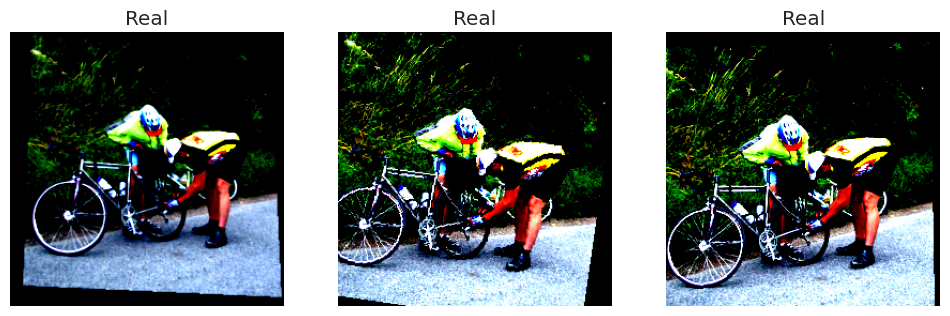

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12, 12))
ind = np.random.randint(train_df.shape[0])
for i in range(3):
    ax[i].imshow(train_dataset[ind][0].permute(1, 2, 0).numpy(),)
    ax[i].set_title(text(train_dataset[ind][1]))
    ax[i].axis("off");

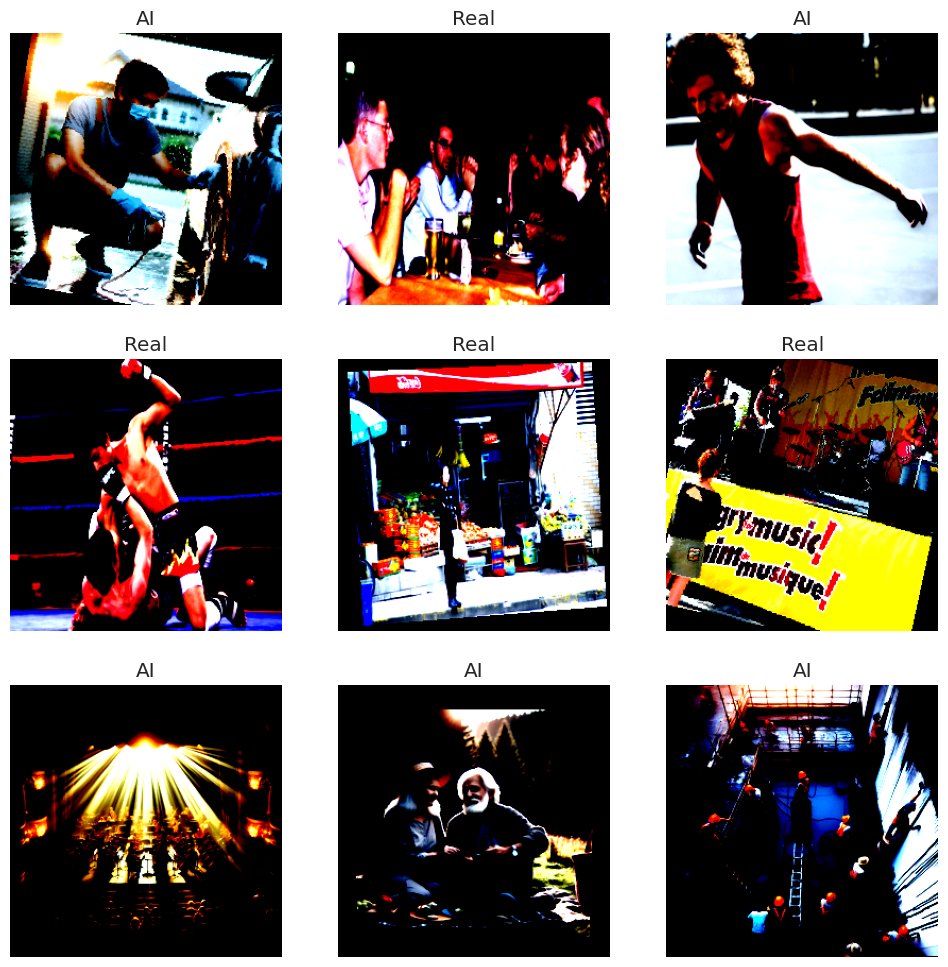

In [ ]:
fig, ax = plt.subplots(3,3, figsize=(12, 12))
for i in range(3):
  for j in range(3):
    ind = np.random.randint(train_df.shape[0])
    ax[i][j].imshow(train_dataset[ind][0].permute(1, 2, 0).numpy(),)
    ax[i][j].set_title(text(train_dataset[ind][1]))
    ax[i][j].axis("off");

##resnet50


### тест модели


In [ ]:
from torchvision.models import resnet50
model = resnet50(pretrained=True)

In [ ]:
model.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 1),
    torch.nn.Sigmoid()
)
model = model.to(device)

In [ ]:
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=1, bias=True)
  (3): Sigmoid()
)

In [ ]:
image_batch = torch.ones((16, 3, 224, 224)).to(device)
with torch.no_grad():
  temp = model(image_batch)
temp.shape

torch.Size([16, 1])

In [ ]:
temp

tensor([[0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065]], device='cuda:0')

In [ ]:
test_1111313 = [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]
torch.tensor(test_1111313)

tensor([0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.])

In [ ]:
criterion = torch.nn.BCELoss()
criterion(torch.tensor(test_1111313),temp.squeeze().cpu())

tensor(81.2500)

In [ ]:
# criterion = torch.nn.BCEWithLogitsLoss()
# criterion(torch.tensor(test_1111313),temp.squeeze().cpu())

tensor(0.7188, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [ ]:
from sklearn.metrics import log_loss

In [ ]:
log_loss(test_1111313,temp.squeeze().detach().cpu().numpy())

12.953187959065723

### train functions

In [ ]:
def plot_learning_curves(history):
    fig = plt.figure(figsize=(20, 7))
    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.subplot(1,2,2)
    plt.title('f1', fontsize=15)
    plt.plot(history['f1']['train'], label='train')
    plt.plot(history['f1']['val'], label='val')
    plt.ylabel('f1', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
def train(model,criterion, optimizer, train_loader, val_loader,  num_epochs, checkpoints_dir=None, scheduler=None,train_aug=None, val_aug=None):
    history = defaultdict(lambda: defaultdict(list))
    device = "cuda" if torch.cuda.is_available() else 'cpu'
    print(device)
    model = model.to(device)
    all_time = 0
    best_f1_macro = 0.0
    for epoch in range(num_epochs):
        train_loss = 0
        train_f1 = 0
        train_for_f1_b = []
        train_for_f1_p = []
        val_loss = 0
        val_f1 = 0
        val_for_f1_b = []
        val_for_f1_p = []
        start_time = time.time()
        model.train()
        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            loss = criterion(logits.squeeze(1), labels.float().to(device))
            loss.backward()
            train_loss += loss.detach().cpu().numpy()
            y_pred = (logits.squeeze().cpu().detach().numpy() > 0.5).astype(int)

            train_for_f1_b = np.append(train_for_f1_b, labels.cpu().numpy())
            train_for_f1_p = np.append(train_for_f1_p, y_pred)
            optimizer.step()
            optimizer.zero_grad()


        train_loss /= len(train_loader)
        train_f1 = f1_score(train_for_f1_b, train_for_f1_p, average="macro")
        history['loss']['train'].append(train_loss)
        history['f1']['train'].append(train_f1)
        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)
        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images = images.to(device)
                labels = labels.to(device)
                logits = model(images)

                loss1 = criterion(logits.squeeze(1), labels.float().to(device))

                val_loss += loss1.detach().cpu().numpy()
                y_pred = (logits.squeeze().cpu().detach().numpy() > 0.5).astype(int)
                val_for_f1_b = np.append(val_for_f1_b, labels.cpu().numpy())
                val_for_f1_p = np.append(val_for_f1_p, y_pred)

        val_loss /= len(val_loader)
        val_f1 = f1_score(val_for_f1_b, val_for_f1_p, average="macro")
        history['loss']['val'].append(val_loss)
        history['f1']['val'].append(val_f1)
        clear_output()
        # Сохраняем лучшую модель по метрике F1-macro
        if checkpoints_dir and val_f1 > best_f1_macro:
            os.makedirs(checkpoints_dir, exist_ok=True)
            best_f1_macro = val_f1
            path = os.path.join(checkpoints_dir, 'best.checkpoint')
            torch.save(model.state_dict(), path)
        # Обновляем learning rate
        if scheduler:
            scheduler.step(val_loss)
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print(" training loss (in-iteration): \t{:.6f}".format(train_loss))
        print(" validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print(" training f1: \t\t\t{:.2f} %".format(train_f1 * 100))
        print(" validation f1: \t\t\t{:.2f} %".format(val_f1 * 100))
        plot_learning_curves(history)
        all_time += (time.time() - start_time)
    return model, history, all_time



###Training

In [ ]:
from torchvision.models import resnet101
model = resnet101(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:06<00:00, 26.5MB/s]


In [ ]:
model.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 1),
    torch.nn.Sigmoid()
)
model = model.to(device)

In [ ]:
criterion = torch.nn.BCELoss()
optimizer = optim.Ranger(model.parameters(), lr=1e-4)
checkpoints_dir = '/content/drive/MyDrive/Test tasks/kontur/resnet101'

Epoch 4 of 10 took 203.201s
 training loss (in-iteration): 	0.024591
 validation loss (in-iteration): 	0.431808
 training f1: 			99.17 %
 validation f1: 			89.53 %


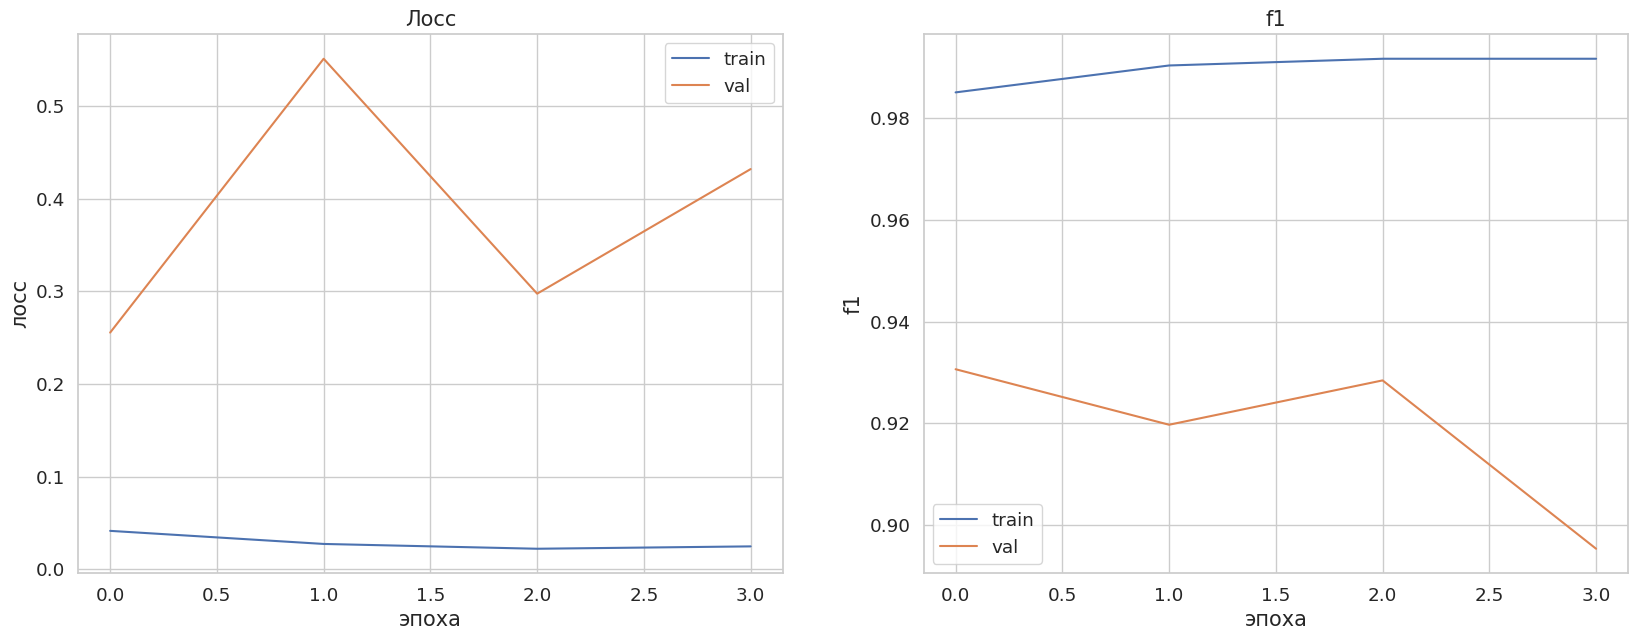

  0%|          | 0/95 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
model, history, all_time = train(
    model, criterion, optimizer,
    train_dataloader, test_dataloader,
    num_epochs=10,checkpoints_dir=checkpoints_dir)

In [ ]:
model

итог $\textbf{logloss=0.2}$ для resnet50

$\textbf{logloss=?}$ для resnet101, недообучал cuda не хватило(

## dualNet

In [ ]:
!unzip '/content/drive/MyDrive/Test tasks/kontur/AI-Generated-Image-Detection-main.zip'

In [ ]:
source_dir = '/content/AI-Generated-Image-Detection-main'

destination_dir = '/content'

files = os.listdir(source_dir)

for file in files:
    source_path = os.path.join(source_dir, file)
    destination_path = os.path.join(destination_dir, file)
    shutil.move(source_path, destination_path)

shutil.rmtree(source_dir)
print("All data moved successfully.")

All data moved successfully.


In [ ]:
#batch = 16, size = (224,224)

In [ ]:
# os.makedirs('models')
# os.makedirs('models/noise')
# os.makedirs('models/rgb')
# os.makedirs('module')
# os.makedirs('utils')

[отсюда моделька DualNet](https://github.com/zoie-ui/AI-Generated-Image-Detection/tree/main)

In [ ]:
from models.DualNet import *

In [ ]:
model = DualNet()
model.fc1

Linear(in_features=512, out_features=2, bias=True)

In [ ]:
model.fc1 = torch.nn.Sequential(
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 1),
    torch.nn.Sigmoid()
)
model.fc1
model = model.to(device)

In [ ]:
criterion = torch.nn.BCELoss(weight=weights)
optimizer = optim.Ranger(model.parameters(), lr=1e-4)
checkpoints_dir = '/content/drive/MyDrive/Test tasks/kontur/dualnet'

In [ ]:
model, history, all_time = train(
    model, criterion, optimizer,
    train_dataloader, test_dataloader,
    num_epochs=40,checkpoints_dir=checkpoints_dir)

итог не очень хороший $\textbf{logloss=1.2}$


##subm

In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
batch_size = 64
sub_transform = transforms.Compose([
  transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
class IMDB_sub(Dataset):
      def __init__(self, root_dir, dataframe, transform=None):
        self.landmarks_frame = dataframe
        # self.landmarks_frame['id'] = self.landmarks_frame['id'].apply(add_extension)
        self.root_dir = root_dir
        self.transform = transform

      def __len__(self):
        return len(self.landmarks_frame)

      def __getitem__(self, idx):

        if torch.is_tensor(idx):
              idx = idx.tolist()
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        # landmarks = self.landmarks_frame.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)

        return image
sub_dataset = IMDB_sub('images',test_sub,sub_transform)
sub_dataloader = DataLoader(sub_dataset, batch_size=batch_size)

In [ ]:
checkpoints_dir = '/content/drive/MyDrive/Test tasks/kontur/dualnet/best.checkpoint'
model.load_state_dict(torch.load(checkpoints_dir))

<All keys matched successfully>

In [ ]:
y_pred = np.array([])
model.train(False)
with torch.no_grad():
  for images in tqdm(sub_dataloader):
      images = images.to(device)
      logits = model(images)
      y_pred = np.append(y_pred, logits.squeeze().cpu().detach().numpy()  )

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
sub = pd.read_csv('sample_submission.csv')

In [ ]:
sub['target']=y_pred

In [ ]:
sub[["target"]].apply(lambda x: round(x,1)).value_counts()

target
0.0       315
1.0       142
0.1         9
0.8         8
0.9         8
0.2         7
0.4         4
0.7         4
0.3         3
0.5         3
0.6         3
Name: count, dtype: int64

In [ ]:
sub.set_index('id').to_csv('dualnet_100epoch.csv')


## full kaggle data



In [ ]:
!pip install kaggle


In [ ]:
import os

os.environ['KAGGLE_CONFIG_DIR'] = '/content'


In [ ]:
!kaggle datasets download -d superpotato9/dalle-recognition-dataset


100% 13.4G/13.4G [02:48<00:00, 118MB/s]
100% 13.4G/13.4G [02:48<00:00, 85.3MB/s]


In [ ]:
!unzip -q dalle-recognition-dataset.zip

In [ ]:
len(os.listdir("/content/real"))

3781

In [ ]:
byai = pd.DataFrame({'image':os.listdir('/content/fakeV2/fake-v2'),'label':1})
byai[['image']] = byai[['image']].apply(lambda x:'/content/fakeV2/fake-v2/'+x)

real = pd.DataFrame({'image':os.listdir('/content/real'),'label':0})
real[['image']] = real[['image']].apply(lambda x:'/content/real/'+x)

##vit


In [ ]:
!pip install -U -q evaluate transformers datasets>=2.14.5 accelerate>=0.27 mlflow 2>/dev/null

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import gc
import numpy as np
import pandas as pd
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    f1_score  )

from imblearn.over_sampling import RandomOverSampler
import accelerate
import evaluate
from datasets import Dataset, Image, ClassLabel
from transformers import (
    TrainingArguments,
    Trainer,
    ViTImageProcessor,
    ViTForImageClassification,
    DefaultDataCollator,
    AutoImageProcessor,
    AutoModel,
    AutoModelForImageClassification,
    SwinForImageClassification,
)
import torch
from torch.utils.data import DataLoader


In [ ]:
device

'cuda'

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
temp = train.copy()
temp[['id']] = train[['id']].apply(lambda x:'images/'+x)

In [ ]:
temp.rename(columns = {'id':'image',"target":'label'},inplace=True)
temp = pd.concat([real,temp, byai])

In [ ]:
# files = list(temp.image)
# images_to_delete = [file for file in files if not file.endswith(('.png', '.jpg', '.jpeg'))]
# print(images_to_delete)
# # for image in images_to_delete:
#     # os.remove(image)
# temp = temp[~temp.image.isin(images_to_delete) ]
# files = list(temp.image)
# images_to_delete = [file for file in files if not file.endswith(('.png', '.jpg', '.jpeg'))]
# print(images_to_delete)

['/content/real/r-art.txt', '/content/fakeV2/fake-v2/sort', '/content/fakeV2/fake-v2/dataset-metadata.json']
[]


In [ ]:
temp.shape

(3780, 2)

In [ ]:
dataset = Dataset.from_pandas(temp).cast_column("image", Image())

In [ ]:
labels_list = [0,1]
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)
dataset = dataset.cast_column('label', ClassLabels)
dataset = dataset.train_test_split(test_size=0.1, shuffle=True,stratify_by_column="label")
train_data = dataset['train']
test_data = dataset['test']

Casting the dataset:   0%|          | 0/3780 [00:00<?, ? examples/s]

In [ ]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
image_mean, image_std = processor.image_mean, processor.image_std

size = processor.size["height"]
print("Size: ", size)
normalize = torchvision.transforms.Normalize(mean=image_mean, std=image_std)

Size:  224


In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
train_transform = transforms.Compose([
  transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomChoice([
    transforms.ColorJitter(brightness=0.2),
    transforms.ColorJitter(contrast=0.2),
    transforms.ColorJitter(saturation=0.2),
    transforms.ColorJitter(hue=0.05),
  ]),
  transforms.RandomChoice([
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop((IMG_HEIGHT, IMG_WIDTH), scale=(0.8, 1.2)),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2),
  ]),
  transforms.RandomChoice([
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 0.5)),
  ]),
  transforms.ToTensor(),
  normalize
])

val_transform = transforms.Compose([
  transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
  transforms.ToTensor(),
  normalize
])

In [ ]:
def train_transforms(examples):
    examples['pixel_values'] = [train_transform(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [val_transform(image.convert("RGB")) for image in examples['image']]
    return examples

In [ ]:
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

In [ ]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=2).to(device)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(model.num_parameters(only_trainable=True) / 1e6)

85.800194


In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    label_ids = eval_pred.label_ids

    predicted_labels = predictions.argmax(axis=1)
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']
    return {
        "accuracy": acc_score
    }


In [ ]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
metric_name = "accuracy"
model_name = "ai_vs_real_image_detection"
num_train_epochs = 10

args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none"
)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [ ]:
trainer.evaluate()

{'eval_loss': 0.6955068707466125,
 'eval_accuracy': 0.488962472406181,
 'eval_runtime': 204.3671,
 'eval_samples_per_second': 22.166,
 'eval_steps_per_second': 0.695}

In [ ]:
temp.image.apply(lambda s: s[-3:]).value_counts()

image
jpg    3391
png     218
peg     171
Name: count, dtype: int64

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.645496,0.648148
2,No log,0.527768,0.788360
3,No log,0.365908,0.894180
4,No log,0.265776,0.904762
5,No log,0.236618,0.917989
6,No log,0.225740,0.915344
7,No log,0.216710,0.917989
8,No log,0.213546,0.920635
9,No log,0.213250,0.915344
10,0.294000,0.210869,0.917989


TrainOutput(global_step=540, training_loss=0.28014789334049933, metrics={'train_runtime': 2643.6613, 'train_samples_per_second': 12.869, 'train_steps_per_second': 0.204, 'total_flos': 2.63627748668842e+18, 'train_loss': 0.28014789334049933, 'epoch': 10.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.028534330427646637,
 'eval_accuracy': 0.9868421052631579,
 'eval_runtime': 8.4877,
 'eval_samples_per_second': 35.817,
 'eval_steps_per_second': 1.178,
 'epoch': 10.0}

лучше всего работает пока что Итоги:


*   0.098 Для [ViT](https://huggingface.co/docs/transformers/model_doc/vit) с 10 эпохами без добавочных данных
*   0.120 Для ViT с 20 эпохами без добавочных данных
*   0.17 Для ViT с 10 эпохами С добавочными данными


везде Softmax, Другие ф-и  активации были не очень


###subm_vit

In [ ]:
shutil.copy('/content/drive/MyDrive/Test tasks/kontur/sparsemax.py','/content')

'/content/sparsemax.py'

In [ ]:
from sparsemax import Sparsemax

In [ ]:
test_sub = pd.read_csv('test.csv')
test_sub['id'] = test_sub['id'].apply(add_extension)
test_sub[['target']]=0

In [ ]:
test_sub[['id']] = test_sub[['id']].apply(lambda x:'images/'+x)
test_sub.rename(columns = {'id':'image',"target":'label'},inplace=True)
subm_dataset = Dataset.from_pandas(test_sub).cast_column("image", Image())


In [ ]:
subm_dataset.set_transform(val_transforms)

In [ ]:
outputs = trainer.predict(subm_dataset)

In [ ]:
y_pred = outputs.predictions
y_pred

array([[ 1.5352559 , -1.4462012 ],
       [-0.20410359,  0.05457514],
       [ 1.5151474 , -1.5161922 ],
       ...,
       [ 1.575998  , -1.6531597 ],
       [-1.0839841 ,  0.8726145 ],
       [-1.0343387 ,  1.0961035 ]], dtype=float32)

In [ ]:
probabilities = nn.functional.softmax(torch.tensor(y_pred), dim=-1)
y_pred = probabilities.numpy()[:,1]
# y_pred

In [ ]:
sub = pd.read_csv('sample_submission.csv')
sub['target']=y_pred
sub[["target"]].apply(lambda x: round(x,1)).value_counts()

target
0.0       226
1.0        94
0.1        93
0.9        54
0.2        13
0.8         9
0.6         6
0.3         4
0.5         3
0.4         2
0.7         2
Name: count, dtype: int64

In [ ]:
sub.set_index('id').to_csv('vit_10ep_softmax_add_data_try2.csv')

## Yolo


In [ ]:
!pip install -q ultralytics

In [ ]:
from ultralytics import YOLO

In [ ]:
train[['id']] = train[['id']].apply(lambda x:'images/'+x)

In [ ]:
real = train[train['target']==0].id
byai = train[train['target']==1].id

In [ ]:
for dir in real:
  shutil.move(dir,'0')
for dir in byai:
  shutil.move(dir,'1')
shutil.rmtree('images')

In [ ]:
data_dir = "data"
classes = ["1", "0"]

train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
val_dir = os.path.join(data_dir, "val")

for c in classes:
    os.makedirs(os.path.join(train_dir, c), exist_ok=True)
    os.makedirs(os.path.join(test_dir, c), exist_ok=True)
    os.makedirs(os.path.join(val_dir, c), exist_ok=True)


In [ ]:
import glob
for c in classes:
    image_paths = glob.glob(os.path.join( c, "*"))
    train_paths, temp = train_test_split(image_paths, test_size=0.2, random_state=42)
    val_paths, test_paths = train_test_split(temp, test_size=0.2, random_state=42)
    for img_path in train_paths:
        shutil.move(img_path, os.path.join(train_dir, c))

    for img_path in test_paths:
        shutil.move(img_path, os.path.join(test_dir, c))

    for img_path in val_paths:
        shutil.move(img_path, os.path.join(val_dir, c))

In [ ]:
data_dir = "data"
classes = ["1", "0"]

train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
val_dir = os.path.join(data_dir, "val")
print(f"Train images '1': {len(os.listdir(os.path.join(train_dir, '1')))},  '0': {len(os.listdir(os.path.join(train_dir, '0')))}")
print(f"Test images  '1': {len(os.listdir(os.path.join(test_dir, '1')))},    '0': {len(os.listdir(os.path.join(test_dir, '0')))}")
print(f"Val images   '1': {len(os.listdir(os.path.join(val_dir, '1')))},   '0': {len(os.listdir(os.path.join(val_dir, '0')))}")


Train images '1': 1556,  '0': 1468
Test images  '1': 78,    '0': 74
Val images   '1': 311,   '0': 293


In [ ]:
model = YOLO('yolov8m-cls.pt').to(device)


In [ ]:
model.train(data='data', epochs=10,single_cls=True)

Ultralytics YOLOv8.1.46 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8m-cls.pt, data=data, epochs=10, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train72, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, l

train: Scanning /content/data/train... 3024 images, 0 corrupt: 100%|██████████| 3024/3024 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/data/train/0/70p8a6cso26a1.jpg: corrupt JPEG restored and saved



val: Scanning /content/data/val... 604 images, 0 corrupt: 100%|██████████| 604/604 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 38 weight(decay=0.0), 39 weight(decay=0.0005), 39 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/train72
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:26<00:00,  1.41s/it]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:28<00:00,  1.48s/it]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:28<00:00,  1.52s/it]

                   all      0.896          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:25<00:00,  1.34s/it]

                   all      0.934          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:29<00:00,  1.55s/it]

                   all      0.922          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:26<00:00,  1.40s/it]

                   all      0.935          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:21<00:00,  1.14s/it]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:27<00:00,  1.43s/it]

                   all      0.945          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:32<00:00,  1.71s/it]

                   all       0.94          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10      1.08G    0.03851         16        224: 100%|██████████| 189/189 [02:09<00:00,  1.46it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:27<00:00,  1.43s/it]

                   all       0.94          1



10 epochs completed in 0.448 hours.
Optimizer stripped from runs/classify/train72/weights/last.pt, 31.7MB
Optimizer stripped from runs/classify/train72/weights/best.pt, 31.7MB

Validating runs/classify/train72/weights/best.pt...
Ultralytics YOLOv8.1.46 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m-cls summary (fused): 103 layers, 15765218 parameters, 0 gradients, 41.6 GFLOPs
train: /content/data/train... found 3024 images in 2 classes ✅ 
val: /content/data/val... found 604 images in 2 classes ✅ 
test: /content/data/test... found 152 images in 2 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:28<00:00,  1.51s/it]


                   all      0.947          1
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train72
Results saved to runs/classify/train72


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b4cad11bd30>
curves: []
curves_results: []
fitness: 0.9735099375247955
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9470198750495911, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9735099375247955}
save_dir: PosixPath('runs/classify/train72')
speed: {'preprocess': 0.11580866693660913, 'inference': 1.0016872393374412, 'loss': 0.0005336786737505174, 'postprocess': 0.0004997316575208247}
task: 'classify'
top1: 0.9470198750495911
top5: 1.0

In [ ]:
metrics = model.val()
metrics.top1
# metrics.top5

Ultralytics YOLOv8.1.46 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m-cls summary (fused): 103 layers, 15765218 parameters, 0 gradients, 41.6 GFLOPs
train: /content/data/train... found 3024 images in 2 classes ✅ 
val: /content/data/val... found 604 images in 2 classes ✅ 
test: /content/data/test... found 152 images in 2 classes ✅ 


val: Scanning /content/data/val... 604 images, 0 corrupt: 100%|██████████| 604/604 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 38/38 [00:42<00:00,  1.11s/it]


                   all      0.947          1
Speed: 0.1ms preprocess, 2.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train722


0.9470198750495911

### yolo subm

In [ ]:
def add_extension(filename):
    if '.' not in filename:
        for file_1 in files:
            if filename in file_1:
                return file_1
    return filename

In [ ]:
!unzip -q "/content/drive/MyDrive/Test tasks/kontur/generated-or-not.zip"


replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
files = np.array(os.listdir('images'))
sub = pd.read_csv('sample_submission.csv')
test_sub = pd.read_csv('sample_submission.csv')
test_sub['id'] = test_sub['id'].apply(add_extension)
test_sub[['id']] = test_sub[['id']].apply(lambda x:'images/'+x)
test_sub.drop('target',axis=1,inplace=True)

In [ ]:
logit[0].probs.data.cpu().tolist()

[3.801309960825317e-16, 1.0]

In [ ]:
y_pred = []
for image in test_sub.id.to_numpy():
  logit = model(image)
  y_pred.append(logit[0].probs.data.cpu().tolist())


image 1/1 /content/images/Qt1fGUB0Vz.jpeg: 224x224 0 1.00, 1 0.00, 14.8ms
Speed: 24.3ms preprocess, 14.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /content/images/j4Rhioq7R3.jpeg: 224x224 1 0.99, 0 0.01, 12.9ms
Speed: 12.4ms preprocess, 12.9ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /content/images/rD0hgFHJUZ.jpeg: 224x224 0 1.00, 1 0.00, 14.8ms
Speed: 8.2ms preprocess, 14.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /content/images/aY5z1EJsJ6.jpeg: 224x224 1 1.00, 0 0.00, 12.8ms
Speed: 28.2ms preprocess, 12.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /content/images/qZ3IoxD2TE.jpeg: 224x224 0 0.95, 1 0.05, 7.5ms
Speed: 8.3ms preprocess, 7.5ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /content/images/BOFtxEERkV.jpeg: 224x224 0 1.00, 1 0.00, 9.5ms
Speed: 7.0ms preprocess, 9.5ms inference, 0.1ms postprocess per i

In [ ]:
len(y_pred),len(y_pred[0])

(506, 2)

In [ ]:
sub['target'] = np.array(y_pred)[:, 1]

In [ ]:
sub[["target"]].apply(lambda x: round(x,1)).value_counts()

target
0.0       264
1.0       159
0.1        21
0.9        14
0.2        12
0.4         8
0.8         8
0.3         6
0.5         6
0.6         4
0.7         4
Name: count, dtype: int64

In [ ]:
sub.set_index('id').to_csv('yolo_20_ep_add_data.csv')

## итоги


Итоги:

---------------------------------------------------------------------
*   **0.098** Для [ViT](https://huggingface.co/docs/transformers/model_doc/vit) с 10 эпохами без добавочных данных
*   **0.120** Для ViT с 20 эпохами без добавочных данных
*   **0.170** Для ViT с 10 эпохами С добавочными данными

---------------------------------------------------------------------

*   **0.0978** для Swinv2 10 поколений
*   **0.137** для Swin уже файтюненого от SDXL 10 поколений
*   **0.157** для Swin SDXL 7 поколений с доп данными
*   **0.08744** для Swin файтюн от Nahrway
---------------------------------------------------------------------

*   **0.203** для ResNet50 с +-40 эпохами файтюн без доп данных
*   *нужно узнать* Для ResNet107 файтюн из huggingface с competition'a
*   **0.234** Для Effnetb7 +-40 эпох без доп данных
---------------------------------------------------------------------

*   **0.236** Для Yolov8m 20 эпох с доп данными

---------------------------------------------------------------------
везде Softmax, Другие ф-и  активации были не очень

плохие попытки были с DualNet(1.2), округление вероятностей по theshhold(2.1), ViT со SparseMax( 1.11)